[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/azad-academy/stable-diffusion-model-tutorial/blob/main/stable-diffusion_tutorial.ipynb)

# Latent Diffusion Models For Image Synthesis 

#### Author : J. Rafid Siddiqui (jrs@azaditech.com)

![Latent Diffusion Model Image](https://raw.githubusercontent.com/azad-academy/stable-diffusion-model-tutorial/main/cover.png)

                                Block Diagram of a Vision Transformer Model [1].
 

### In order to access the model, you will have to login using huggingface account. If you don't have one, you can signup freely on the huggingface website. After signing in to your account, visit the following link and click on the Access Respository button after agreeing to the license agreement. 

[Stable Diffusion Model Repository](https://huggingface.co/CompVis/stable-diffusion-v1-4)


# Pre-requisites, Imports and Initializers

In [1]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"
!wget https://raw.githubusercontent.com/huggingface/diffusers/4674fdf807cdefd4db1758067c0207872d805f8c/examples/inference/image_to_image.py
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-09-19 12:39:37--  https://raw.githubusercontent.com/huggingface/diffusers/4674fdf807cdefd4db1758067c0207872d805f8c/examples/inference/image_to_image.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6808 (6.6K) [text/plain]
Saving to: ‘image_to_image.py.3’

image_to_image.py.3 100%[===================>]   6.65K  --.-KB/s    in 0s      

2022-09-19 12:39:37 (92.4 MB/s) - ‘image_to_image.py.3’ saved [6808/6808]

Looking in indexes: https://pypi.org/simple, http

In [2]:
from google.colab import output
from pathlib import Path
from PIL import Image
import torch
from diffusers import StableDiffusionPipeline
import requests
import getpass
from io import BytesIO
from image_to_image import StableDiffusionImg2ImgPipeline, preprocess
import os, wget

output.enable_custom_widget_manager()
cache_drive = False

### Mounting the Google Drive (Optional)
Execute this, If you would want to keep the session active and not login or download model again and again.

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

cache_dir = "/content/drive/MyDrive/Colab Notebooks/weights" #@param {type:"string"}
cache_drive = True

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Text to Image Synthesis


In [4]:
# Helping function for plotting images in a 2D grid

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


### Downloading and Loading Pre-trained Text to Image Model

Create an 'Access Token' on the Huggingface website by visiting the Settings -> 'Access Tokens' and Clicking on the 'New Token' button.

![Screenshot1 Image](https://github.com/azad-academy/stable-diffusion-model-tutorial/raw/main/hf_screen1.png)
![Screenshot2 Image](https://github.com/azad-academy/stable-diffusion-model-tutorial/raw/main/hf_screen2.png)

In [5]:
if not cache_drive:
    cache_dir = "/content/weights"
flag = False
Enable_NSFW = False #@param {type:"boolean"}
for p in Path(cache_dir).rglob("*"):
    if p.name == "model_index.json":
        flag = True
        print(f"Cache dir Found: {p.parent}")
        break
if flag:
    print("Loading the model, Please Wait...")
    pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path=p.parent, revision="fp16", torch_dtype=torch.float16, use_auth_token=False)
else:
    token = getpass.getpass("Cache not Found, Enter Your HuggingFace Access token Here:")
    token = token.strip()
    print("Loading the model, Please Wait...")
    pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", cache_dir=cache_dir, revision="fp16", torch_dtype=torch.float16, use_auth_token=token)
print("Model Loaded Successfully!")
if Enable_NSFW:
    pipe.safety_checker = lambda images, **kwargs: (images, False)
pipe = pipe.to("cuda")

Cache dir Found: /content/drive/MyDrive/Colab Notebooks/weights/models--CompVis--stable-diffusion-v1-4/snapshots/a304b1ab1b59dd6c3ba9c40705c29c6de4144096
Loading the model, Please Wait...
Model Loaded Successfully!


Enter a text sentence in the prompt and see the results in the form of an image.

0it [00:00, ?it/s]

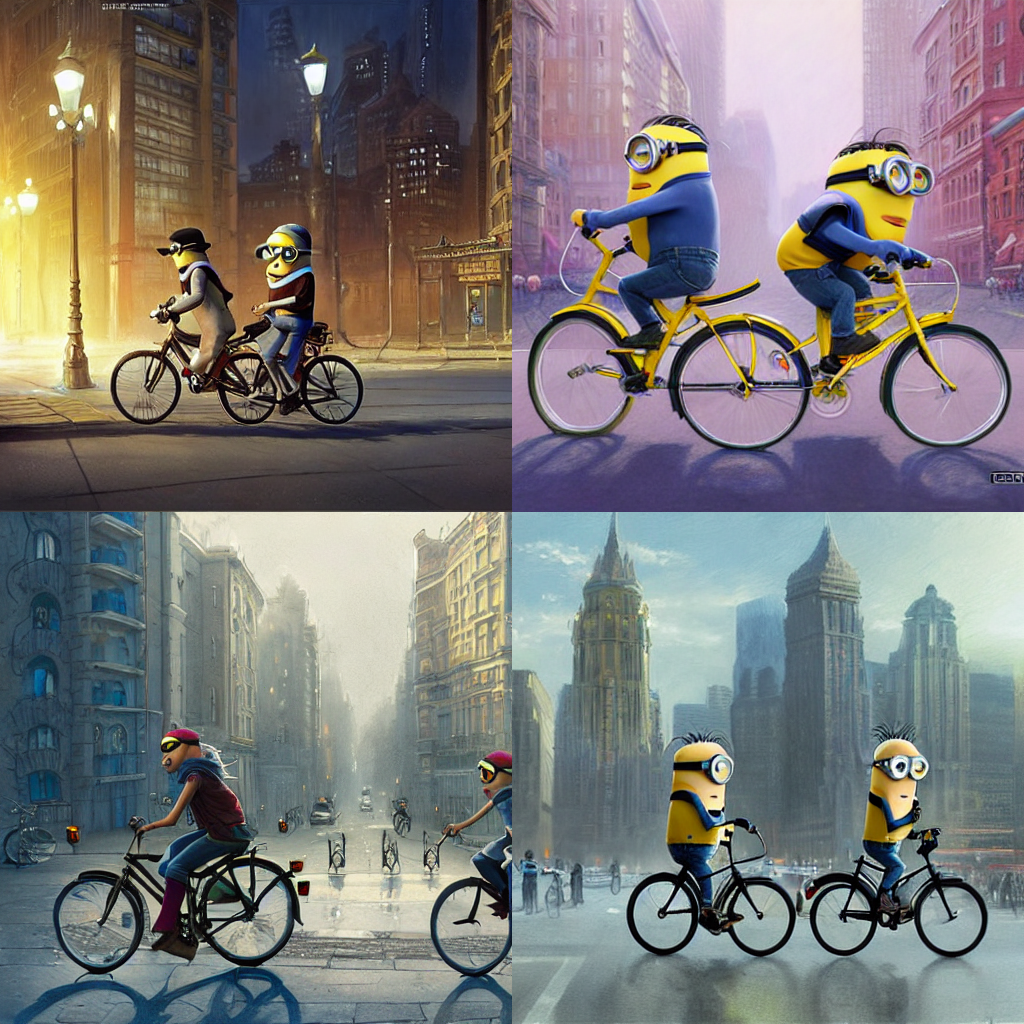

In [14]:
#@title # Stable Diffusion txt2img
prompt = "Two minions riding a bicycle in the city, with the Guru, tone mapped, shiny, intricate, cinematic lighting, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by terry moore and greg rutkowski" #@param {type:"string"}

#@markdown Height of the Image:
H = 512 #@param {type:"slider", min:256, max:1024, step:64}

#@markdown Width of the Image:
W = 512 #@param {type:"slider", min:256, max:1024, step:64}

#@markdown Number of images to generate:
n = 4 #@param {type:"integer"}

#@markdown Seed:
seed = 3 #@param {type:"integer"}

#@markdown Steps to generate the image(lower number->faster but crappier image):
steps = 50 #@param {type:"slider", min:1, max:150, step:1}

#@markdown How strong your text prompt should influence the image(default 7.5)
guidance_scale = 7.5 #@param {type:"slider", min:6, max:15, step:0.1}

#@markdown ### Display Settings
show_grid = True #@param {type:"boolean"}
#@markdown If you have `show_grid` enabled, make sure `n = rows*columns`
#@markdown , Ignore if you have `show_grid` disabled.

prompt = [prompt] * n
generator = torch.Generator("cuda").manual_seed(seed)
with torch.autocast("cuda"):
    images = pipe(prompt, num_inference_steps=steps, generator=generator, height=H, width=W, guidance_scale=guidance_scale)["sample"]
    del generator

if show_grid:
    rows = 2 #@param {type:"integer"}
    columns = 2 #@param {type:"integer"}
    grid = image_grid(images, rows=rows, cols=columns)
    display(grid)

## Image to Image Synthesis

### Downloading Random Images For Testing

In [9]:

def download_sample_images(num_imgs):
  for i in range(0,num_imgs):
    filename = f"{i}.jpg"
    if os.path.exists(filename):
      os.remove(filename)
    wget.download("https://picsum.photos/384",out=filename)

num_imgs = 3
download_sample_images(num_imgs)

In [10]:
from PIL import Image
from matplotlib import pyplot as plt

# Load images from disk and display them
def load_images(img_dir,num_imgs):
  imgs = []
  fig,axes = plt.subplots(1,num_imgs,figsize=(20,10))
  for i in range(0,num_imgs):
    img = Image.open(img_dir+f'{i}.jpg')
    imgs.append(img)
    axes[i].imshow(img)
    axes[i].set_axis_off()
  fig.tight_layout()
  return imgs

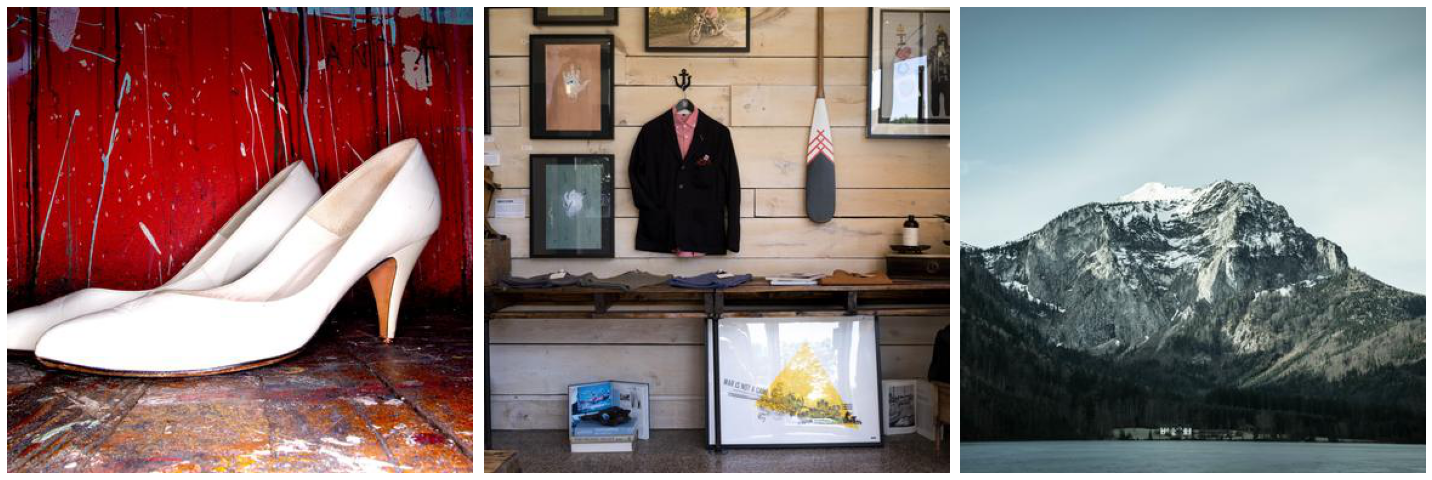

In [11]:
imgs = load_images("./",num_imgs)

### Stable Diffusion: Image to Image Synthesis

In [27]:
captions = ["" for i in range(3)]
#@title # Add a Caption for each image above in the following textboxes
captions[0] = "A pair of white female shoes lying on the floor" #@param {type:"string"}
captions[1] = "Multiple paintings are hanging on the wall" #@param {type:"string"}
captions[2] = "A lake with a snowy mountain in the background" #@param {type:"string"}  

### Loading an Image to Image Model

In [12]:
if not cache_drive:
    cache_dir = "/content/weights"
flag = False
Enable_NSFW = False #@param {type:"boolean"}
for p in Path(cache_dir).rglob("*"):
    if p.name == "model_index.json":
        flag = True
        print(f"Cache Found: {p.parent}")
        break
if flag:
    print("Loading the model, Please Wait...")
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(pretrained_model_name_or_path=p.parent, revision="fp16", torch_dtype=torch.float16, use_auth_token=False)
else:
    token = getpass.getpass("Cache not Found, Enter Your HuggingFace Access token Here:")
    token = token.strip()
    print("Loading the model, Please Wait...")
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", cache_dir=cache_dir, revision="fp16", torch_dtype=torch.float16, use_auth_token=token)
print("Model Loaded Successfully!")
if Enable_NSFW:
    pipe.safety_checker = lambda images, **kwargs: (images, False)
pipe = pipe.to("cuda")

Cache not Found, Enter Your HuggingFace Access token Here:··········
Loading the model, Please Wait...


Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Model Loaded Successfully!


0it [00:00, ?it/s]

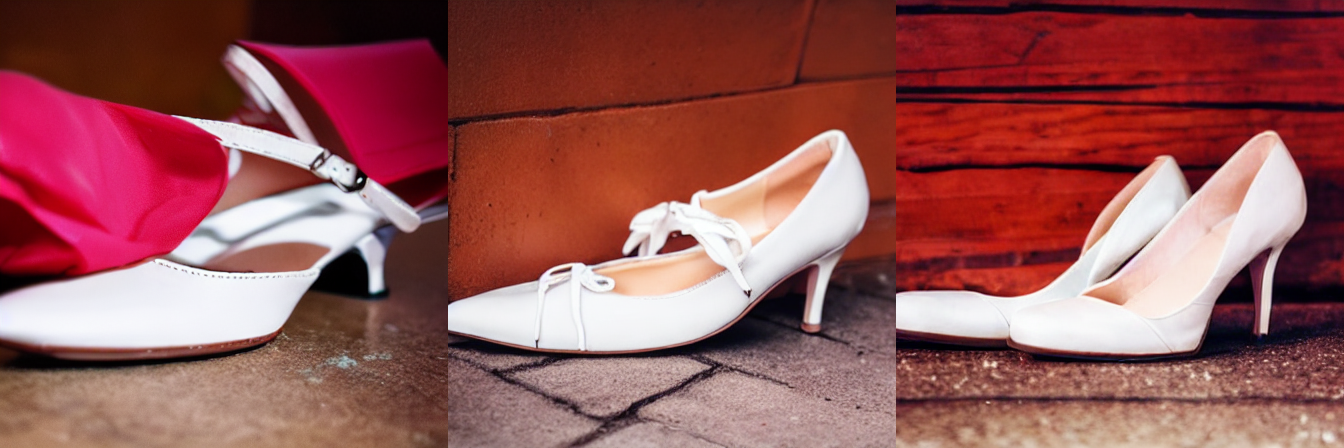

0it [00:00, ?it/s]

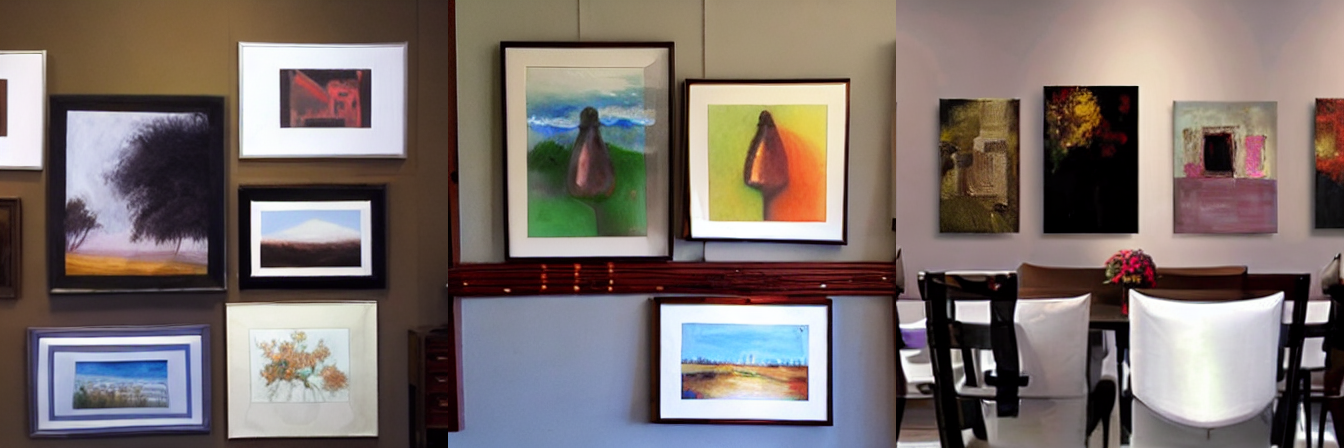

0it [00:00, ?it/s]

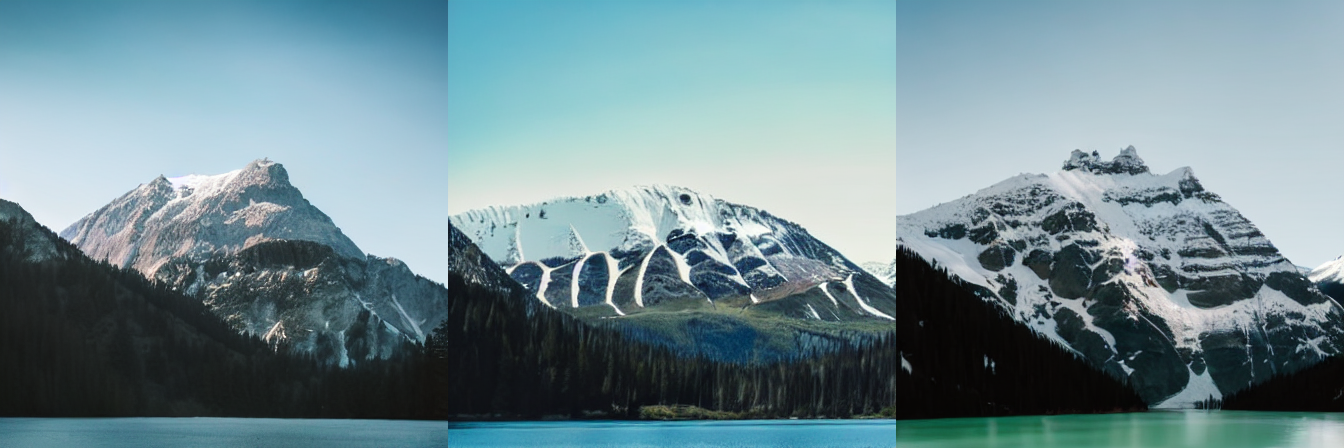

In [28]:

H = 450 
W = 450 

#@markdown Seed:
seed = 3 #@param {type:"integer"}

#@markdown Steps to generate the image(lower number->faster but crappier image):
steps = 70 #@param {type:"slider", min:1, max:150, step:1}

#@markdown How strong your text prompt should influence the image(default 7.5)
guidance_scale = 7.5 #@param {type:"slider", min:6, max:15, step:0.1}


for i in range(3):
  #input_image = Image.open(path_to_input_image).convert("RGB")
  img = imgs[i]
  input_image = img.resize((W, H))
  input_image_array = preprocess(input_image)

  generator = torch.Generator("cuda").manual_seed(seed)
  with torch.autocast("cuda"):
      prompt = [captions[i]]*num_imgs
      images = pipe(prompt, init_image=input_image_array, num_inference_steps=steps, generator=generator, guidance_scale=guidance_scale)["sample"]
      del generator

  #@markdown ### Display Settings
  show_grid = True #@param {type:"boolean"}
  if show_grid:
      #new_grid = [input_image, images[0]]
      grid = image_grid(images,rows=1,cols=3)  #Show three images for each original image
      display(grid)
  else:
      display(images[0])

# References

[1] Jonathan Ho, Ajay Jain, Pieter Abbeel, "[Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)", 2020

[2] Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever,"[Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)", 2021

[3] Robin Rombach and Andreas Blattmann and Dominik Lorenz and Patrick Esser and Björn Ommer, "[High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752)", arXiv:2112.10752, 2021, 

[4] Blattmann, Andreas and Rombach, Robin and Oktay, Kaan and Ommer, Björn, "[Retrieval-Augmented Diffusion Models](https://arxiv.org/abs/2204.11824)",  CVPR, 2022,

[5] Blattmann et. al., Latent Diffusion Models, https://github.com/CompVis/latent-diffusion, 2022
